In [52]:
using Plots
using LaTeXStrings

target(x::Float64) = (x^3-15*x^2+7*x+1)/10
target_ravine(p) = sum(p .* p)
target_ravine_2(p) = p[1]^2 + 100*p[2]^2
simplex_test_func(x) = 3*(x[1]-5)^2 + 7*(x[2]-10)^2
function target_rastrygin(p)
    A = 10
    result = A*length(p)
    for idx in 1:length(p)
        result += p[idx]^2 - A*cos(2*pi*p[idx])
    end
    return result
end
function target_schefill(p)
    A = 418.9829
    result = A*length(p)
    for idx in 1:length(p)
        result -= p[idx]*sin(sqrt(abs(p[idx])))
    end
    return result
end
target_rosenbrock(p) = (1 - p[1])^2 + 100*(p[2] - p[1]^2)^2

global Lf_max=0
function df(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - f(points[idx-1]))/(points[idx+1]-points[idx-1]))
        global Lf_max = max(Lf_max, max(abs(result[end])))
    end
    return result
end

function grad(f, x, eps=1e-6)
    result = zeros(length(x))
    for i in 1:length(x)
        next_x = copy(x)
        next_x[i] += eps
        result[i] = (f(next_x) - f(x)) / eps
    end
    return result
end

function ddf(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - 2 * f(points[idx]) + f(points[idx-1]))/(points[idx+1]-points[idx])^2)x_candidate
    end
    return result
end

function ddf_with_points(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - 2 * f(points[idx]) + f(points[idx-1]))/(points[idx+1]-points[idx])^2)
    end
    return result, points[2:length(points)-1]
end

function get_fib(n)
    sqrt5 = sqrt(5)
    trunc(Int, (1 / sqrt5) * (((1 + sqrt5) / 2)^n - ((1  - sqrt5) / 2)^n))
end

function is_unimodal_df(f, a, b, N=1000)
    deriv = df(f, range(a, b, N))
    last_deriv = deriv[1]
    for current_deriv in deriv[2:length(deriv)-1]
        if current_deriv <= last_deriv
            return false
        end
    end
    return true
end

function is_unimodal_ddf(f, a, b, N=1000)
    for current_deriv in ddf(f, range(a, b, N))
        if current_deriv < 0
            return false
        end
    end
    return true
end

function search_unimodal_segment(f, a, b, N=1000)
    deriv, points = ddf_with_points(f, range(a, b, N))
    interval_start, interval_end = nothing, nothing
    result_start, result_end = nothing, nothing
    for (second_deriv, point) in zip(deriv, points)
        if second_deriv < 0
            if interval_start != nothing
                if (interval_end - interval_start) > (result_end - result_start)
                    result_start, result_end = interval_start, interval_end
                end
                interval_start = nothing
                interval_end = nothing
            end
        elseif second_deriv > 0
            if interval_start == nothing
                interval_start = point
            end
            interval_end = point
        end
    end
    if result_end == nothing || result_start == nothing
        return interval_start, interval_end    
    end
    if (interval_end - interval_start) > (result_end - result_start)
        result_start, result_end = interval_start, interval_end
    end
    return result_start, result_end
end

function norm(p)
    return sqrt(sum(p .* p))
end

norm (generic function with 1 method)

In [2]:
function function_min_iter(f, start, stop, n)
    dots = []
    step = (stop - start) / n
    min_value = f(start)
    min_point = start
    for i in 1:n
        x = start + i * step
        append!(dots, x)
        if f(x) < min_value
            min_value = f(x)
            min_point = x
        end
    end
    error = (stop - start)/n
    return min_point, dots, error, n
end

function function_min_dyhotomy(f, a, b, eps=1.e-6)
    dots = []
    iter = 0
    while abs(b - a) > eps
        iter += 1
        mid = (a + b) / 2
        f1 = f(mid - eps)
        f2 = f(mid + eps)
        append!(dots, mid - eps)
        append!(dots, mid + eps)
        if f1 < f2
            b = mid
        else
            a = mid
        end
    end
    error = Lf_max * eps / 2
    return (a + b) / 2, dots, error, iter
end

function function_min_dyhotomy_impl(f, a, b, eps=1.e-6)
    while abs(b - a) > eps
        mid = (a + b) / 2
        f1 = f(mid - eps)
        f2 = f(mid + eps)
        if f1 < f2
            b = mid
        else
            a = mid
        end
    end
    return (a + b) / 2
end

function function_min_golden(f, start, stop, eps=1.e-6)
    phi = (sqrt(5.0) - 1) / 2
    dots = []
    iter = 0
    while abs(stop - start) > eps
        iter += 1
        c = stop - (stop - start) * phi
        d = start + (stop - start) * phi
        append!(dots, c)
        append!(dots, d)
        if f(c) < f(d)
            stop = d
        else
            start = c
        end
    end
    error = Lf_max * phi * eps
    return (start + stop) / 2, dots, error, iter
end

function function_min_fib(f, a, b, n, eps=1.e-6)
    x1 = a + (get_fib(n) / get_fib(n + 2)) * (b - a)
    x2 = a + b - x1
    y1 = f(x1)
    y2 = f(x2)
    dots = []
    iter = 0
    while abs(b - a) > eps
        iter += 1
        if y1 <= y2
            b = x2
            x2 = x1
            x1 = a + b - x1
            y2 = y1
            y1 = f(x1)
        else
            a = x1
            x1 = x2
            x2 = a + b - x2
            y1 = y2
            y2 = f(x2)
        end

        append!(dots, (a + b) / 2)
    end
    error = Lf_max * eps
    return (a + b) / 2, dots, error, iter
end

function_min_fib (generic function with 2 methods)

In [76]:
function sven_localization(f, x_0, h = 0.01)
    x_i = []
    x_0 = copy(x_0)
    push!(x_i, x_0)
    direction = 1
    x = x_0 + direction * h
    if f(x) > f(x_0)
        direction = -1
        x = x_0 + direction * h
    end
    push!(x_i, x)
    while f(x + direction * h) < f(x)
        h *= 2
        buf = x_0
        x_0 = x
        x = buf + direction * h
        push!(x_i, x)
    end
    if size(x_i)[1] > 2
        return minmax(x_i[end], x_i[lastindex(x_i) - 1])
    else
        return minmax(x_i[end], x_i[lastindex(x_i) - 1])
    end
    
end

function one_dim_optimize(f, x_0=0.0)
    a, b = sven_localization(f, x_0)
    x_opt = function_min_dyhotomy_impl(f, a, b) 
    return x_opt
end

function one_dim_optimize_test(f, x_0=0.0)
    a = 0
    b = 2*x_0
    x_opt = function_min_dyhotomy_impl(f, a, b) 
    return x_opt
end

function coordinate_descent(f, x_0, h_0, eps = 1e-6)
    alpha = h_0
    x = [x_0]
    k = 0
    while true
        x_min = copy(x[end])
        k += 1

        for i in 1:length(x_0)
            e_k = x[end][i] / norm(x[end])
            x_i_new_1 = x[end][i] + alpha * e_k
            x_i_new_2 = x[end][i] - alpha * e_k

            x_candidate = copy(x[end])

            x_candidate[i] = x_i_new_1
            if f(x_min) > f(x_candidate)
                x_min = x_candidate
            end

            x_candidate[i] = x_i_new_2
            if f(x_min) > f(x_candidate)
                x_min = x_candidate
            end
        end
        if norm(x_min - x[end]) < eps
            break
        end
        if f(x_min) < f(x[end])
            push!(x, x_min)
        else
            alpha = alpha * 0.5
        end   
        
        if length(x) > 1 && norm(x[end] - x[end-1]) < eps
            break
        end
    end
    return x[end], k, x
end

function hooke_jeeves_method(f, x_0, h_0, eps = 1e-6)
    alpha = h_0
    x = [x_0]
    k = 0
    points_added = 1
    while true
        x_min = copy(x[end])
        k += 1
        
        if points_added > 0 && points_added == 3
            points_added = 1
            x0 = copy(x[lastindex(x) - 2])
            x1 = copy(x[lastindex(x) - 1])
            x2 = copy(x[end])
            x_min = 2*x2-x0
            push!(x, x_min)
        end        
            
        for i in 1:length(x_0)
            x_i_new_1 = x[end][i] + alpha
            x_i_new_2 = x[end][i] - alpha
            x_candidate = copy(x[end])
            x_candidate[i] = x_i_new_1
            if f(x_min) > f(x_candidate)
                x_min = copy(x_candidate)
            end
            x_candidate[i] = x_i_new_2
            if f(x_min) > f(x_candidate)
                x_min = copy(x_candidate)
            end
        end
        
        if norm(x_min - x[end]) < eps
            break
        end
        if f(x_min) < f(x[end])
            push!(x, x_min)
            points_added+=1 
        else
            alpha *= 0.5 
        end   
        if length(x) > 1 && norm(x[end] - x[end-1]) < eps
            break
        end
        
    end
    return x[end], k, x
end

function Gauss_Zeidel(f, x_0, h_0, eps = 1e-6)
    alpha = h_0
    x = [x_0]
    k = 0
    while true 
        k += 1
        x_min = copy(x[end])
        for i in 1:length(x_0)
            x_candidate = copy(x[end])
            
            e_k = zeros(length(x_0))
            e_k[i] = x_candidate[i] / norm(x_candidate)
        
            g(a) = f(x_candidate + a*e_k)
            alpha_new = one_dim_optimize(g, alpha)
            x_new_i_1 = x_candidate + alpha_new * e_k
            x_new_i_2 = x_candidate - alpha_new * e_k

            if f(x_min) > f(x_new_i_1)
                x_min = x_new_i_1
                alpha = alpha_new
            end

            if f(x_min) > f(x_new_i_2)
                x_min = x_new_i_2
                alpha = alpha_new
            end
        end
        push!(x, x_min)
        if length(x) > 1 && norm(x[end] - x[end-1]) < eps
            break
        end
    end
    return x[end], k, x
end

Gauss_Zeidel (generic function with 2 methods)

In [4]:
function simplex_method(f, eps=1e-6, max_iter=1000)
    x = [ [0.0, 0.0], [(sqrt(3)+1)/(2*sqrt(2)), (sqrt(3)-1)/(2*sqrt(2))], [(sqrt(3)-1)/(2*sqrt(2)), (sqrt(3)+1)/(2*sqrt(2))]]
    triangles = [copy(x)]
    x_4 = []
    iterations = 0
    for idx in 1:max_iter
        if(f(x[2]) >= f(x[1]) && f(x[2]) >= f(x[3]))
            temp = x[1]
            x[1] = x[2]
            x[2] = temp
        elseif (f(x[3]) >= f(x[1]) && f(x[3]) >= f(x[2]))
            temp = x[1]
            x[1] = x[3]
            x[3] = temp
        end
        x4 = x[2] + x[3] - x[1]
        push!(x_4, x4)
        if(f(x4) >= f(x[2]) && f(x4) >= f(x[3]))
            x[1] = x4
            x[2] = x4+(x[2] - x4)/2
            x[3] = x4+(x[3] - x4)/2
            push!(triangles, [x4, x[2], x[3]])
        else
            x[1] = x4
            push!(triangles, [x4, x[2], x[3]])
        end
        iterations = idx
        if norm(x[1]- x[2]) < 1e-3
            break
        end
    end
    return x[1], iterations, triangles, x_4
end

# отражение, сжатие, растяжение
function nelder_mead(f, eps=1e-6, max_iter=1000, alpha=1, beta=0.5, gamma=2)
    x = [ [0.0, 0.0], [(sqrt(3)+1)/(2*sqrt(2)), (sqrt(3)-1)/(2*sqrt(2))], [(sqrt(3)-1)/(2*sqrt(2)), (sqrt(3)+1)/(2*sqrt(2))]]
    trajectory = []
    mid = []
    x_4 = []
    x_5 = []
    trac = []
    iterations = 0
    for idx in 1:max_iter
        x = sort(x, by = x->f(x), rev=true)
        push!(trajectory, x[3])
        trajectory = vcat(trajectory, x) 
        x_mid = (x[2] + x[3]) / 2
        x4 = x_mid + alpha * (x_mid - x[1])
        
        push!(mid, x_mid)
        push!(x_4, x4)
        push!(trac, x[1], x4)

        if f(x4) < f(x[3])
            # a)
            # Значение в отображенной точке (x4) меньше наилучшего из x
            # Растягиваем симлекс с gamma = 2
            x5 = gamma * x4 + (1 - gamma) * x_mid
            x[1] = (f(x5) < f(x4)) ? x5 : x4 
            push!(x_5, x5)
            push!(trac, x[1], x5)
        else
            # b)
            if f(x[3]) < f(x4) < f(x[2])
                # Значение в отображенной точке x4 больше наилучшего, но меньше среднего x2
                x[1] = x4
            else
                if f(x[2]) < f(x4) < f(x[1])
                    # Значение в отображенной точке x4 больше среднего, но меньше наихудшего x1
                    x[1] = x4
                end
                
                x = sort(x, by = x->f(x), rev=true)
                x5 = (x[1] +  x_mid) / 2
                if f(x5) < f(x[1])
                    # Точка сжатаго симплекса меньше наихудшей точки симплекса - заменяем
                    x[1] = x5
                else
                    # c)
                    x[1] = x[3] + 1/2 * (x[1] - x[3])
                    x[2] = x[3] + 1/2 * (x[2] - x[3])
                end

                push!(x_5, x5)
                push!(trac, x[1], x5)   
            end
        end
        sort(x, by = x->f(x), rev=true)
        fx = [(f(vert) - f(x_mid))^2 for vert in x]
        if sqrt(sum(fx) / 3) < eps
            break
        end
        iterations = idx
    end
    
    return x[3], iterations, trajectory, mid, trac, x_4, x_5
end

function grad_descent(func, x0, alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6)
    descent_rate = alpha  
    iterations = 0
    points = []
    push!(points, x0)
    while iterations < max_iter
        x = copy(points[end])
        gradient = grad(func, x)
        next_x = x - descent_rate * gradient
        if norm(next_x - x) <= eps || abs(func(next_x)-func(x)) <= func_eps || norm(gradient) <= grad_eps
            break
        end
        if func(next_x) < func(x)
            push!(points, next_x)
        else
            descent_rate /= 2
        end
        iterations+=1 
    end
    return points[end], iterations, points
end

grad_descent (generic function with 6 methods)

In [78]:
function fast_grad_descent(func, x0, alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6)
    descent_rate = alpha  
    iterations = 0
    points = []
    push!(points, x0)
    while iterations < max_iter
        x = copy(points[end])
        gradient = grad(func, x)
        g(a) = func(x - a*gradient)
        descent_rate = one_dim_optimize_test(g, descent_rate)
        next_x = x - descent_rate * gradient
        if norm(next_x - x) <= eps
            break
        end
        push!(points, next_x)
        iterations+=1 
    end
    return points[end], iterations, points
end

function conj_grad_descent(func, x0, alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6)
    descent_rate = alpha  
    iterations = 0
    points = []
    push!(points, x0)
    conj = grad(func, x0)
    while iterations < max_iter
        x = copy(points[end])
        g(a) = func(x - a*conj)
        descent_rate = one_dim_optimize_test(g, descent_rate)
        next_x = x - descent_rate * conj
        if norm(next_x - x) <= eps
            break
        end
        push!(points, next_x)
        new_grad = grad(func, next_x)
        conj = new_grad + norm(new_grad)^2/norm(grad(func, x))^2 * conj
        iterations+=1 
    end
    return points[end], iterations, points
end

conj_grad_descent (generic function with 6 methods)

In [74]:
#import Pkg; Pkg.add("Gaston"); Pkg.add("SpecialFunctions")
using PlotlyJS, SpecialFunctions

function plot_method(f, points, func_min, iterations, title)
    x = y = -1:0.1:1
    px = [points[i][1] for i in 1:length(points)]
    py = [points[i][2] for i in 1:length(points)]
    
    plt = Plots.plot(size=(1000, 1000), title=title, xlim=(-0.5,0.5), ylim=(-0.5,0.5))
    Plots.plot!(plt, x, y, (x,y)->f([x,y]), st = :contour, levels=:40)
    Plots.plot!(plt, px, py, seriestype=:scatter, color = "blue")
    Plots.plot!(plt, px, py, color = "blue")
    Plots.plot!(plt, [func_min[1]], [func_min[2]], seriestype=:scatter, color = "red", label="min")
    Plots.plot!(plt, [], [], labels="iterations=$(iterations)")
    return plt
end  

function run_and_plot_optimization(func, x0, h0)
    # Запуск всех методов оптимизации для заданной функции
    h_min, h_iter, path_hooke = hooke_jeeves_method(func, x0, h0, 1e-9)
    xmin, _, path_coord = coordinate_descent(func, x0, h0)
    _, _, path_gauss = Gauss_Zeidel(func, x0, h0)
    
    # Создание поверхности один раз
    x_vals = range(-10, 10, length=50)
    y_vals = range(-10, 10, length=50)
    Z = [func([x, y]) for x in x_vals, y in y_vals]
    
    # Объединяем все в один график
    p = PlotlyJS.plot(
        [
            PlotlyJS.surface(z=Z, x=x_vals, y=y_vals, colorscale="Viridis", opacity=0.6),
            PlotlyJS.scatter3d(x=first.(path_hooke), y=last.(path_hooke), z=[func(p) for p in path_hooke],
                             mode="markers+lines", marker=attr(size=5, color="red"),
                             name="Метод Хука-Дживса"),
            PlotlyJS.scatter3d(x=first.(path_coord), y=last.(path_coord), z=[func(p) for p in path_coord],
                             mode="markers+lines", marker=attr(size=5, color="blue"),
                             name="Метод покоординатного спуска"),
            PlotlyJS.scatter3d(x=first.(path_gauss), y=last.(path_gauss), z=[func(p) for p in path_gauss],
                             mode="markers+lines", marker=attr(size=5, color="green"),
                             name="Метод Гаусса-Зейделя")
        ]
    )
    
    # Отображение графика
    return display(p)
end

function optimize_func(func, x0, h0, title="")
    hooke_jeeves_min, hooke_jeeves_iterations, hooke_jeeves_points = hooke_jeeves_method(func, x0, h0)
    coordinate_descent_min, coordinate_descent_iterations, coordinate_descent_points = coordinate_descent(func, x0, h0)
    gauss_zeidel_min, gauss_zeidel_iterations, gauss_zeidel_points = Gauss_Zeidel(func, x0, h0)
    if title != ""
        print("$(repeat('=', 20))$(title)$(repeat('=', 20))\n")
    end
    print("HookeJeeves: k = ", hooke_jeeves_iterations, "    x_min = (", hooke_jeeves_min[1], ", ", hooke_jeeves_min[2], ")\n")
    print("CoordDescent: k = ", coordinate_descent_iterations, "    x_min = (", coordinate_descent_min[1], ", ", coordinate_descent_min[2], ")\n")
    print("GaussZeidel: k = ", gauss_zeidel_iterations, "    x_min = (", gauss_zeidel_min[1], ", ", gauss_zeidel_min[2], ")\n")
    print("$(repeat('=', 50))\n")

    x_vals = range(-10, 10, length=50)
    y_vals = range(-10, 10, length=50)
    Z = [func([x, y]) for x in x_vals, y in y_vals]
    
    p = PlotlyJS.plot(
        [
            PlotlyJS.surface(z=Z, x=x_vals, y=y_vals, colorscale="Viridis", opacity=0.6),
            PlotlyJS.scatter3d(x=first.(hooke_jeeves_points), y=last.(hooke_jeeves_points), z=[func(p) for p in hooke_jeeves_points],
                             mode="markers+lines", marker=attr(size=5, color="red"),
                             name="Метод Хука-Дживса"),
            PlotlyJS.scatter3d(x=first.(coordinate_descent_points), y=last.(coordinate_descent_points), z=[func(p) for p in coordinate_descent_points],
                             mode="markers+lines", marker=attr(size=5, color="blue"),
                             name="Метод покоординатного спуска"),
            PlotlyJS.scatter3d(x=first.(gauss_zeidel_points), y=last.(gauss_zeidel_points), z=[func(p) for p in gauss_zeidel_points],
                             mode="markers+lines", marker=attr(size=5, color="green"),
                             name="Метод Гаусса-Зейделя")
        ]
    )
    p1 = plot_method(func, hooke_jeeves_points, hooke_jeeves_min, hooke_jeeves_iterations, "HookeJeeves")
    p2 = plot_method(func, coordinate_descent_points, coordinate_descent_min, coordinate_descent_iterations, "CoordDescent")
    p3 = plot_method(func, gauss_zeidel_points, gauss_zeidel_min, gauss_zeidel_iterations, "GaussZeidel")
    display(Plots.plot(p1, p2, p3))
    # Отображение графика
    return display(p)
end

optimize_func (generic function with 2 methods)

In [99]:
function plot_method_triangles(f, triangles, func_min, iterations, tested_points, title)
    x = y = -1.5:0.1:1.5
    plt = Plots.plot(size=(1000, 1000), title=title)
    Plots.plot!(plt, x, y, (x,y)->f([x,y]), st = :contour, levels=:40)
    px = [tested_points[i][1] for i in 1:length(tested_points)]
    py = [tested_points[i][2] for i in 1:length(tested_points)]
    Plots.plot!(plt, px, py, label="x4", seriestype=:scatter, legend=:topleft, color = "yellow", ms=3, ma=0.7)
    for idx in 1:length(triangles)
        px = [ triangles[idx][i][1] for i in 1:length(triangles[idx]) ]
        py = [ triangles[idx][i][2] for i in 1:length(triangles[idx]) ]
        #Plots.plot!(plt, px, py, label=false, seriestype=:line, legend=:topleft, color = "green")
        Plots.plot!(plt, [triangles[idx][1][1], triangles[idx][3][1]], [triangles[idx][1][2], triangles[idx][3][2]], label=false, seriestype=:line, legend=:topleft, color = "green")
        Plots.plot!(plt, [triangles[idx][1][1], triangles[idx][2][1]], [triangles[idx][1][2], triangles[idx][2][2]], label=false, seriestype=:line, legend=:topleft, color = "green")
        Plots.plot!(plt, [triangles[idx][2][1], triangles[idx][3][1]], [triangles[idx][2][2], triangles[idx][3][2]], label=false, seriestype=:line, legend=:topleft, color = "green")
    end
    Plots.plot!(plt, [func_min[1]], [func_min[2]], seriestype=:scatter, color = "red", label="min")
    Plots.plot!(plt, [], [], labels="iterations=$(iterations)")
    return plt
end

function plot_method_nedler(f, trajectory, func_min, iterations, trac, x4, x5, mid , title)
    x = y = -1.5:0.1:1.5
    plt = Plots.plot(size=(1000, 1000), title=title)
    Plots.plot!(plt, x, y, (x,y)->f([x,y]), st = :contour, levels=:40)
    
    px_mid = [mid[i][1] for i in 1:length(mid)]
    py_mid = [mid[i][2] for i in 1:length(mid)]
    px_x4 = [x4[i][1] for i in 1:length(x4)]
    py_x4 = [x4[i][2] for i in 1:length(x4)]
    px_x5 = [x5[i][1] for i in 1:length(x5)]
    py_x5 = [x5[i][2] for i in 1:length(x5)]
    px_trac = [trac[i][1] for i in 1:length(trac)]
    py_trac = [trac[i][2] for i in 1:length(trac)]
    x_coords = [point[1] for point in trajectory]
    y_coords = [point[2] for point in trajectory]
    
    Plots.plot!(x_coords, y_coords, label="trajectory", legend=:topleft, color = "green")
    for i in 1:2:Int(length(px_trac)/2)
        Plots.plot!(px_trac[i:i+1], py_trac[i:i+1], label=false, linestyle=:dash, legend=:topleft, color = "blue")  
    end

    Plots.plot!(px_mid, py_mid, label="middle", seriestype=:scatter, legend=:topleft, color = "blue", ms=3)
    Plots.plot!(px_x4, py_x4, label="x4", seriestype=:scatter, legend=:topleft, color = "yellow", ms=3, ma=0.7)
    Plots.plot!(px_x5, py_x5, label="x5", seriestype=:scatter, legend=:topleft, color = "white", ms=3, ma=0.7)
    
    Plots.plot!(plt, [func_min[1]], [func_min[2]], seriestype=:scatter, color = "red", label="min")
    Plots.plot!(plt, [], [], labels="iterations=$(iterations)")
    return plt
end

function optimize_func_figures(func, x0 = [1,1], title="")
    simple_result, simple_iterations, simple_triangles, simple_x_4 = simplex_method(func)
    print("SimplexMethod: iterations = ", simple_iterations, "    x_min = (", simple_result[1], ", ", simple_result[2], ")\n")
    nelder_result, nelder_iterations, nelder_trajectory, nelder_mid,  nelder_trac, nelder_x4, nelder_x5 = nelder_mead(func)
    print("NelderMead: iterations = ", nelder_iterations, "    x_min = (", nelder_result[1], ", ", nelder_result[2], ")\n")
    grad_result, grad_iterations, grad_points = grad_descent(func, x0)
    print("GradDescent: iterations = ", grad_iterations, "    x_min = (", grad_result[1], ", ", grad_result[2], ")\n")
    p1 = plot_method_triangles(func, simple_triangles, simple_result, simple_iterations, simple_x_4, "SimplexMethod")
    p2 = plot_method_nedler(func, nelder_trajectory, nelder_result, nelder_iterations, nelder_trac, nelder_x4, nelder_x5, nelder_mid, "NelderMead")
    p3 = plot_method(func, grad_points, grad_result, grad_iterations, "GradDescent")
    display(Plots.plot(p1, p2, p3))
    
    x_vals = range(-10, 10, length=50)
    y_vals = range(-10, 10, length=50)
    Z = [func([x, y]) for x in x_vals, y in y_vals]
    simple_traj = []
    for triang in simple_triangles
        push!(simple_traj, triang[1], triang[2], triang[3], triang[1])
    end
    
    p = PlotlyJS.plot(
        [
            PlotlyJS.surface(z=Z, x=x_vals, y=y_vals, colorscale="Viridis", opacity=0.6),
            PlotlyJS.scatter3d(x=first.(simple_traj), y=last.(simple_traj), z=[func(p) for p in simple_traj],
                             mode="markers+lines", marker=attr(size=5, color="red"),
                             name="Симплексный метод"),
            PlotlyJS.scatter3d(x=first.(nelder_trajectory), y=last.(nelder_trajectory), z=[func(p) for p in nelder_trajectory],
                             mode="markers+lines", marker=attr(size=5, color="blue"),
                             name="Метод Нидла-Мида"),
            PlotlyJS.scatter3d(x=first.(grad_points), y=last.(grad_points), z=[func(p) for p in grad_points],
                             mode="markers+lines", marker=attr(size=5, color="blue"),
                             name="Метод Градиентного спуска"),
        ]
    )
end

optimize_func_figures (generic function with 3 methods)

In [50]:
function optimize_grad_func(func, x0, title="")
    fast_grad_result, fast_grad_iterations, fast_grad_points = fast_grad_descent(func, x0)
    conj_grad_result, conj_grad_iterations, conj_grad_points = conj_grad_descent(func, x0)
    grad_result, grad_iterations, grad_points = grad_descent(func, x0)
    if title != ""
        print("$(repeat('=', 20))$(title)$(repeat('=', 20))\n")
    end
    print("GradDescent: iterations = ", grad_iterations, "    x_min = (", grad_result[1], ", ", grad_result[2], ")\n")
    print("FastestGradDescent: iterations = ", fast_grad_iterations, "    x_min = (", fast_grad_result[1], ", ", fast_grad_result[2], ")\n")
    print("ConjugateGradDescent: iterations = ", conj_grad_iterations, "    x_min = (", conj_grad_result[1], ", ", conj_grad_result[2], ")\n")
    print("$(repeat('=', 50))\n")

    x_vals = range(-10, 10, length=50)
    y_vals = range(-10, 10, length=50)
    Z = [func([x, y]) for x in x_vals, y in y_vals]
    
    p = PlotlyJS.plot(
        [
            PlotlyJS.surface(z=Z, x=x_vals, y=y_vals, colorscale="Viridis", opacity=0.6),
            PlotlyJS.scatter3d(x=first.(fast_grad_points), y=last.(fast_grad_points), z=[func(p) for p in fast_grad_points],
                             mode="markers+lines", marker=attr(size=5, color="red"),
                             name="Метод наискорейшего спуска"),
            PlotlyJS.scatter3d(x=first.(conj_grad_points), y=last.(conj_grad_points), z=[func(p) for p in conj_grad_points],
                             mode="markers+lines", marker=attr(size=5, color="blue"),
                             name="Метод сопряженных градиентов"),
            PlotlyJS.scatter3d(x=first.(grad_points), y=last.(grad_points), z=[func(p) for p in grad_points],
                             mode="markers+lines", marker=attr(size=5, color="blue"),
                             name="Метод Градиентного спуска"),
        ]
    )
    p1 = plot_method(func, fast_grad_points, fast_grad_result, fast_grad_iterations, "FastestGradDescent")
    p2 = plot_method(func, conj_grad_points, conj_grad_result, conj_grad_iterations, "ConjugateGradDescent")
    p3 = plot_method(func, grad_points, grad_result, grad_iterations, "GradDescent")
    display(Plots.plot(p1, p2, p3))
    # Отображение графика
    return display(p)
end

optimize_grad_func (generic function with 2 methods)

====================Test====================
GradDescent: iterations = 517    x_min = (0.006303185693873346, -5.000000000233767e-7)
FastestGradDescent: iterations = 496    x_min = (5.8093032782424745e-5, 3.570437919106509e-7)
ConjugateGradDescent: iterations = 96    x_min = (0.00013128329429450632, 4.6500832287524074e-7)


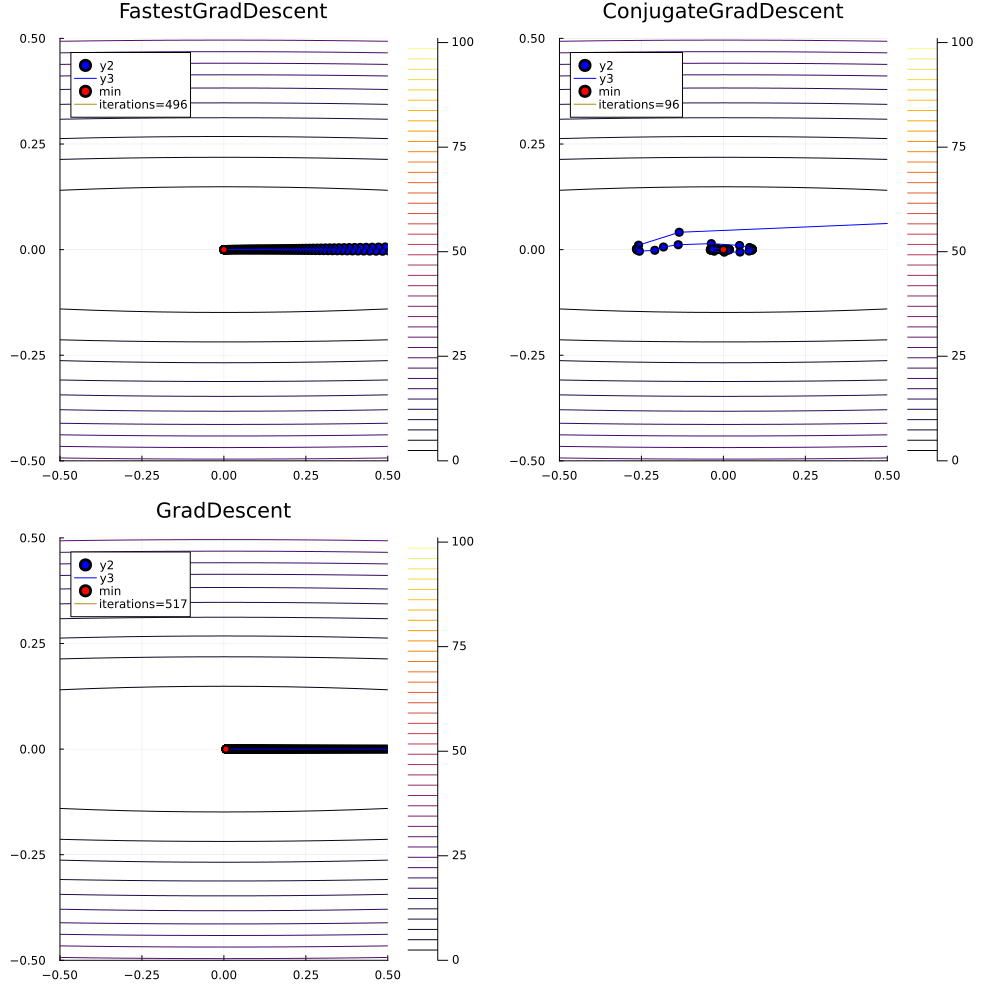

data: [
  "surface with fields colorscale, opacity, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z"
]

layout: "layout with fields margin and template"

In [79]:
optimize_grad_func(target_ravine_2, [4.0,4.0], "Test")

====================Rosenbrock====================
GradDescent: iterations = 1000    x_min = (1.3974181598003226, 1.954039408641985)
FastestGradDescent: iterations = 1000    x_min = (-1.2536130842805306, 1.5771093622933359)
ConjugateGradDescent: iterations = 305    x_min = (1.0005465208054596, 1.00109656178109)


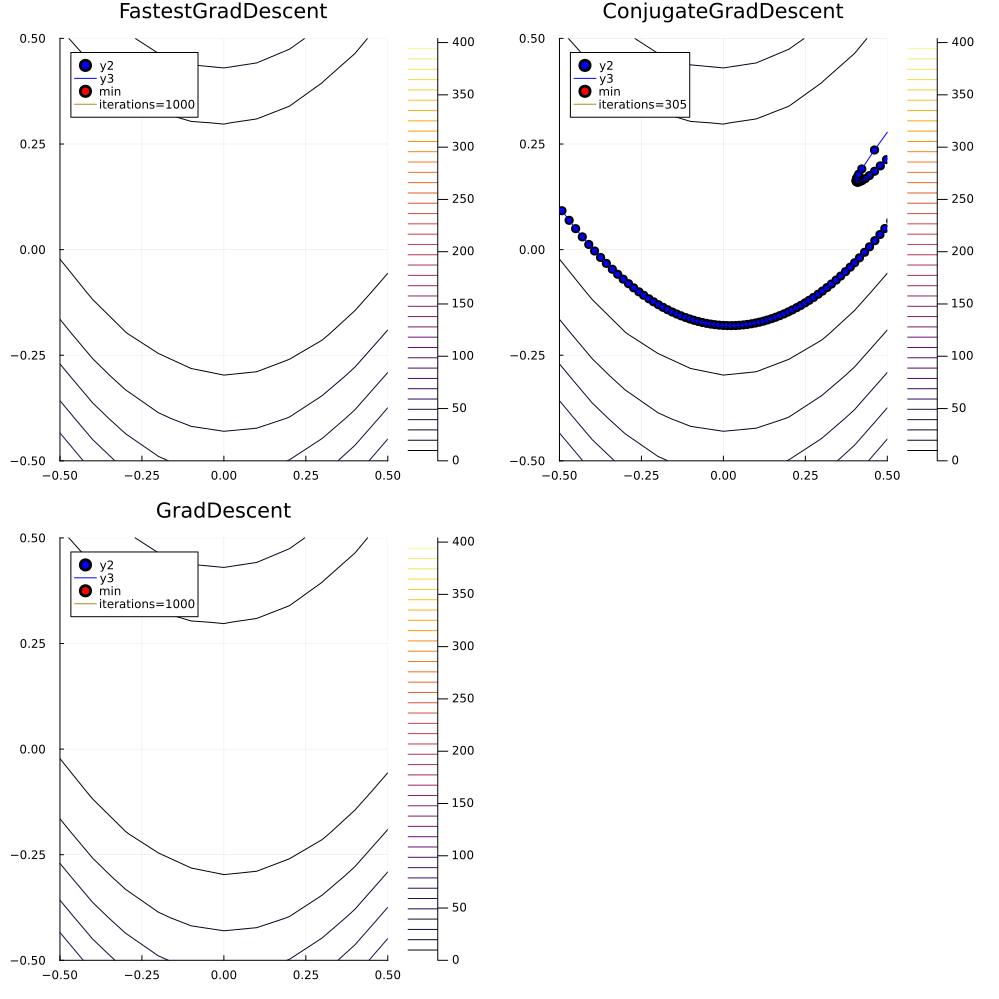

data: [
  "surface with fields colorscale, opacity, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z"
]

layout: "layout with fields margin and template"

In [80]:
optimize_grad_func(target_rosenbrock, [2.0,2.2], "Rosenbrock")

====================Rastrygin====================
GradDescent: iterations = 12    x_min = (3.97973196522727, 2.9848415139575106)
FastestGradDescent: iterations = 2    x_min = (3.9797837643058664, 3.9797831810221664)
ConjugateGradDescent: iterations = 3    x_min = (3.979783550486158, 3.979783914913538)


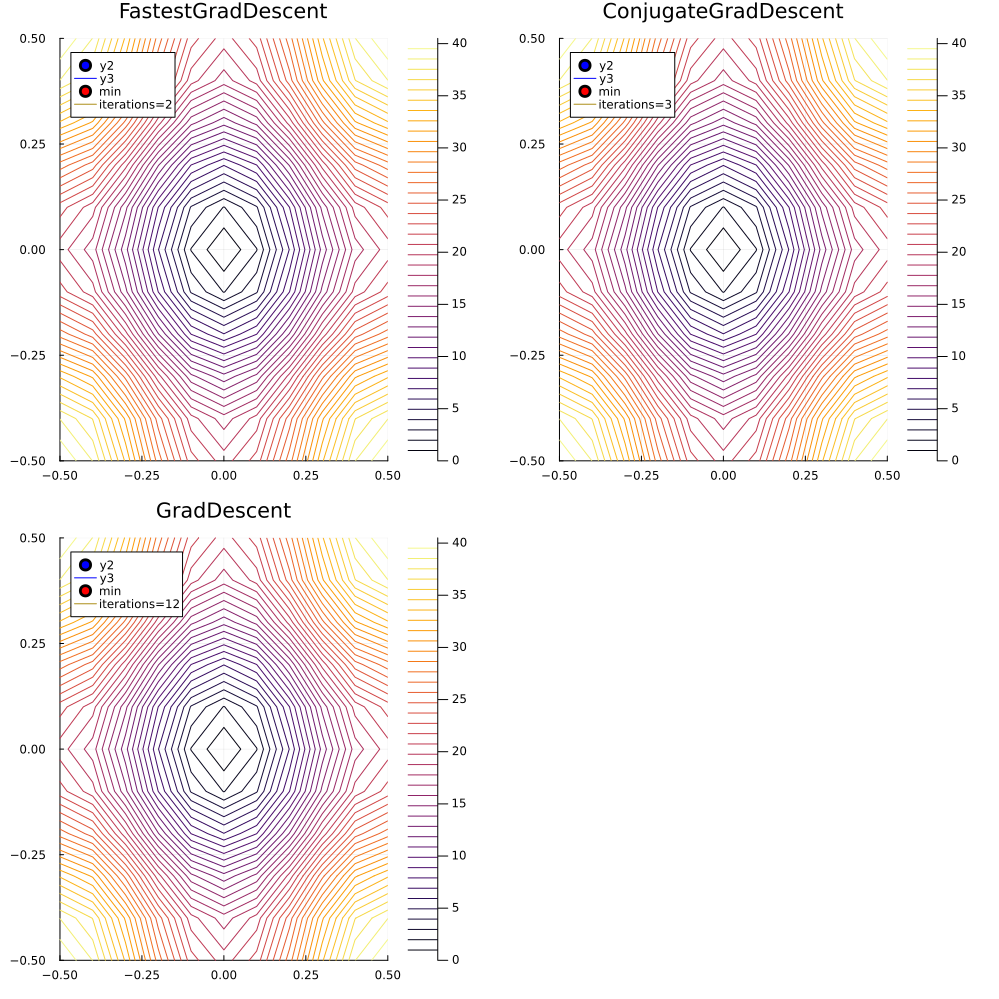

data: [
  "surface with fields colorscale, opacity, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z"
]

layout: "layout with fields margin and template"

In [81]:
optimize_grad_func(target_rastrygin, [4.0, 4.1], "Rastrygin")

====================Schefill====================
GradDescent: iterations = 157    x_min = (5.233811128211528, 5.233811128211528)
FastestGradDescent: iterations = 1000    x_min = (5.239088728843213, 5.2390796299038245)
ConjugateGradDescent: iterations = 5    x_min = (5.239198674633663, 5.239198674633663)


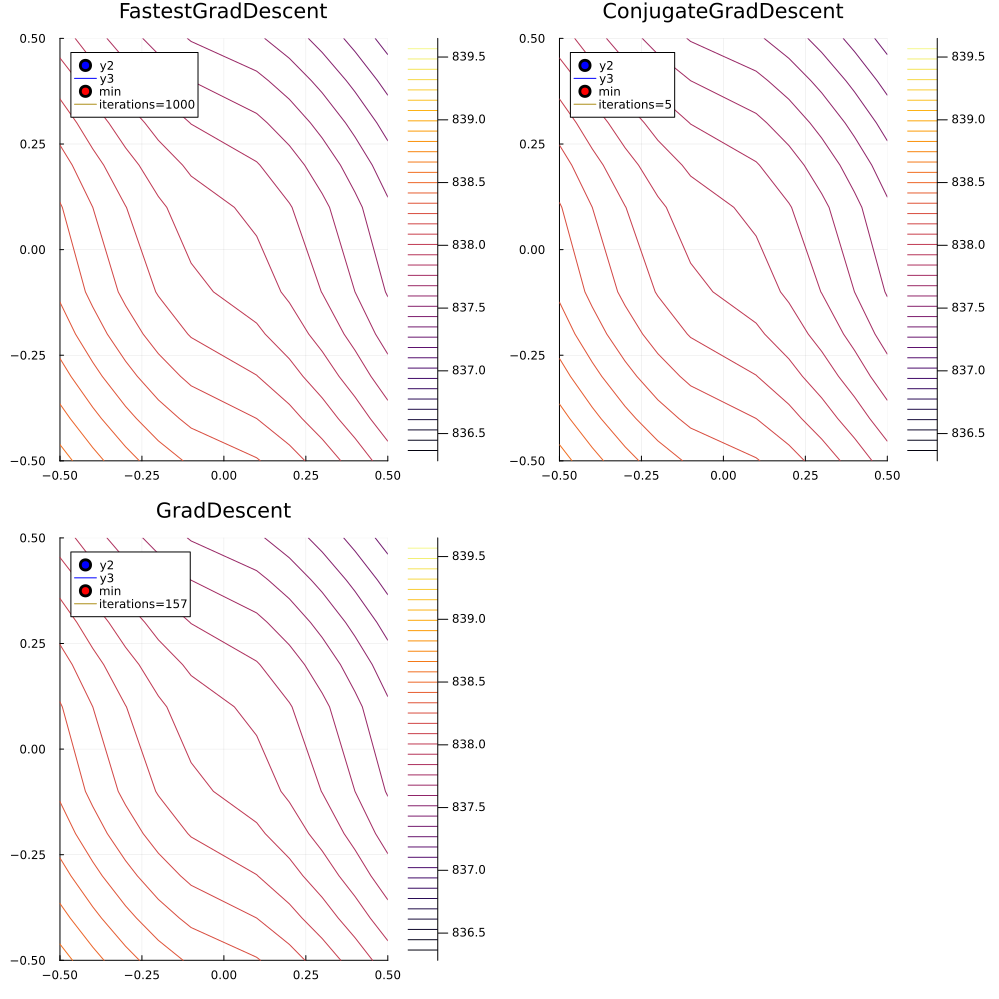

data: [
  "surface with fields colorscale, opacity, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z",
  "scatter3d with fields marker, mode, name, type, x, y, and z"
]

layout: "layout with fields margin and template"

In [82]:
optimize_grad_func(target_schefill, [2.0, 2.0], "Schefill")